In [3]:
from PIL import Image
import os
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import euler_number
import matplotlib.pyplot as plt
import os
import numpy as np
import openpnm as op
import openpnm.models as mods
from openpnm.models import physics as pm
import pandas as pd

np.random.seed(0)

# PATH = r'C:\Users\rtopa\OneDrive\phd22\gan\pnm\openpnm'
# PATH = r'C:\Users\rtopa\OneDrive\phd22\pnm\openpnm'
# os.chdir(PATH)
im = np.load('1.npy')
# raw_file = np.fromfile('Berea_2d25um_binary.raw', dtype=np.uint8)
# im = (raw_file.reshape(1000,1000,1000))

# running snow algorithm to extract pore geometry information from network
snow = ps.networks.snow(
    im,
    voxel_size=2.32e-06)

# extracting network and geometry from snow simulation results
proj = op.io.PoreSpy.import_data(snow)

pn,geo = proj[0],proj[1]

# check the health of network
health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2022-08-13 19:44:51,269
------------------------------------------------------------


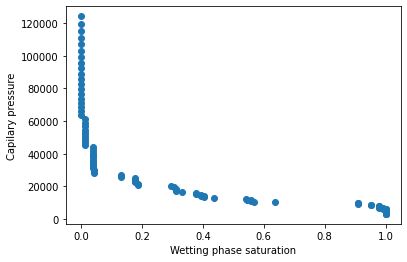

In [5]:
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
water['pore.contact_angle'] = 0
air['pore.contact_angle'] = 180
# water['pore.surface_tension'] = 0.064
# air['pore.surface_tension'] = 0.064


phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

inlets = pn.pores('bottom')
outlets = pn.pores('top')
OP_1 = op.algorithms.OrdinaryPercolation(network=pn,phase=air)
OP_1.set_inlets(pores=inlets)
OP_1.setup(phase=air, pore_volume='pore.volume', throat_volume='throat.volume')
OP_1.run(points=100)

data = OP_1.get_intrusion_data()
sw = [1-x for x in data.Snwp]
snw = data.Snwp
f = plt.figure()
plt.scatter(sw,data.Pcap)
plt.xlabel('Wetting phase saturation')
plt.ylabel('Capilary pressure')
# print(data.Pcap)
# print(data.Snwp)
pc_data = {'Sw':np.array(sw),'Pc':np.array(data.Pcap)}
pc_data = pd.DataFrame(pc_data)
# pc_data.to_excel('pc-data_op.xlsx')

In [6]:
def update_phase_and_phys_water(results):
    # convert results to boolean matrix
    results['pore.occupancy'] = results['pore.occupancy'].astype(int) > 0
    results['throat.occupancy'] = results['throat.occupancy'].astype(int) > 0
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of water, we need to update phys_water hydraulic conductance.
    #  The percoaltion result is always refering to air since this is phase we we are using to invade
    # Therefore, locations where water hydraulic conductance is slow indicate gas saturated
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val

def update_phase_and_phys_air(results):
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

    results['pore.occupancy'] = results['pore.occupancy'].astype(int) > 0
    results['throat.occupancy'] = results['throat.occupancy'].astype(int) > 0
    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of air, we need to update phys_air hydraulic conductance.
    # Therefore, locations where air hydraulic conductance is slow indicate water saturated
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val


In [7]:
def stokes_flow(phase,inlet,outlet):
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=phase)
    # in boundary front water saturation is 1
    # Boundary pores with constant condition
    # left is the inlet of flow
    st.set_value_BC(pores=pn.pores(inlet), values=0)
    # outlet of flow
    st.set_value_BC(pores=pn.pores(outlet), values=1) # this part needs some validation
    st.run()
    return st

def cal_absolute_perm(image_size,resolution,Q):
    A = (image_size*image_size) *resolution**2 # m^2
    L = image_size * resolution # m
    mu = water['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1 # 1-0
    K = Q * L * mu / (A * delta_P)
    return K/0.98e-12*1000

def cal_eff_perm(image_size,resolution,Q,phase):
    A = (image_size*image_size) *resolution**2
    L = image_size * resolution
    mu = phase['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1
    K = Q * L * mu / (A * delta_P)

    return K/0.98e-12*1000

im_shape = 128
resolution = 2.32e-06

# absolute permeability of water
phys_water.regenerate_models()
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
# in boundary front water saturation is 1
# Boundary pores with constant condition
# left is the inlet of flow
st.set_value_BC(pores=inlets, values=0)
# outlet of flow
st.set_value_BC(pores=outlets, values=1) # this part needs some validation
st.run()

Q_abs_water = st.rate(pores=outlets,mode='group')
kabs_water = cal_absolute_perm(im_shape,resolution,Q_abs_water[0])
print(f'Absolute permeability is {kabs_water}md')
proj.purge_object(obj=st)



Absolute permeability is 204.62681815652988md


In [8]:
# simulation of multphase kr for water
keff_water = []
phys_water.regenerate_models()
for Pc in data.Pcap:
    update_phase_and_phys_water(OP_1.results(Pc=Pc))
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=water)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,water)
    keff_water.append(keff)
    proj.purge_object(obj=st)
    phys_water.regenerate_models()

In [9]:
keff_air = []
phys_air.regenerate_models()
for Pc in data.Pcap:
    update_phase_and_phys_air(OP_1.results(Pc=Pc))
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=air)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,air)
    keff_air.append(keff)
    proj.purge_object(obj=st)
    phys_air.regenerate_models()

In [10]:
kr_water = np.array(keff_water)/kabs_water
kr_air = np.array(keff_air)/kabs_water
kr_data = {'Snw':snw,'kr_air':kr_air,'kr_water':kr_water}
kr_data =pd.DataFrame(kr_data)
# kr_data.to_excel('kr-data_opflowrate.xlsx')

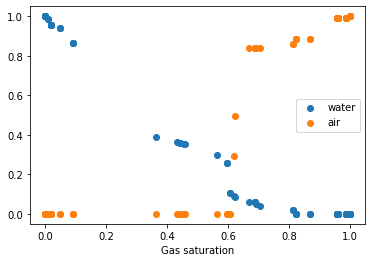

In [11]:
plt.scatter(snw,np.array(keff_water)/kabs_water,label='water')
plt.scatter(snw,np.array(keff_air)/kabs_water,label='air')
plt.xlabel('Gas saturation')
plt.legend()

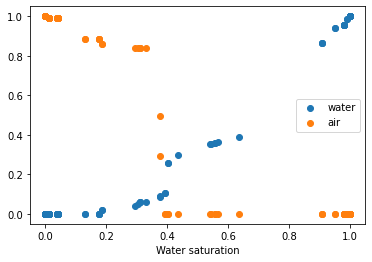

In [12]:
plt.scatter(sw,np.array(keff_water)/kabs_water,label='water')
plt.scatter(sw,np.array(keff_air)/kabs_water,label='air')
plt.xlabel('Water saturation')
plt.legend()

#### The residual gas saturation is 0.6
#### The irreducible water saturation is 0.2